árbol clasificación
May 18, 2023

In [1]:
# Tratamiento de datos
# ------------------------------------------------------------------------------
import numpy as np
import pandas as pd
import statsmodels.api as sm
# Gráficos
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
# Preprocesado y modelado
# ------------------------------------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.tree import export_graphviz
from sklearn.tree import export_text
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
# Configuración warnings
# ------------------------------------------------------------------------------
import warnings
warnings.filterwarnings('once')


In [2]:
carseats = sm.datasets.get_rdataset("Carseats", "ISLR")
datos = carseats.data
print(carseats.__doc__)

.. container::

   ======== ===============
   Carseats R Documentation
   ======== ===============

   .. rubric:: Sales of Child Car Seats
      :name: sales-of-child-car-seats

   .. rubric:: Description
      :name: description

   A simulated data set containing sales of child car seats at 400
   different stores.

   .. rubric:: Usage
      :name: usage

   ::

      Carseats

   .. rubric:: Format
      :name: format

   A data frame with 400 observations on the following 11 variables.

   ``Sales``
      Unit sales (in thousands) at each location

   ``CompPrice``
      Price charged by competitor at each location

   ``Income``
      Community income level (in thousands of dollars)

   ``Advertising``
      Local advertising budget for company at each location (in
      thousands of dollars)

   ``Population``
      Population size in region (in thousands)

   ``Price``
      Price company charges for car seats at each site

   ``ShelveLoc``
      A factor with levels ``Bad``,

In [3]:
datos.head(3)

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes


In [4]:
datos['ventas_altas'] = np.where(datos.Sales > 8, 0, 1)
# Una vez creada la nueva variable respuesta se descarta la original
datos = datos.drop(columns = 'Sales')

0.0.1 Ajuste del modelo
Se ajusta un árbol de clasificación empleando como variable respuesta ventas_altas y como predictores todas las variables disponibles. Se utilizan en primer lugar los hiperparámetros max_depth=5
y criterion=‘gini’, el resto se dejan por defecto. Después, se aplica el proceso de pruning y se comparan los resultados frente al modelo inicial.
A diferencia del ejemplo anterior, en estos datos hay variables categóricas por lo que, antes de
entrenar el modelo, es necesario aplicar one-hot-encoding. Puede encontrarse una descripción más
detallada de este proceso en Machine learning con Python y Scikit-learn.

In [5]:
# División de los datos en train y test
# ------------------------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
datos.drop(columns = 'ventas_altas'),
datos['ventas_altas'],
random_state = 123
)
# One-hot-encoding de las variables categóricas
# ------------------------------------------------------------------------------
# Se identifica el nobre de las columnas numéricas y categóricas
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()
numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()
# Se aplica one-hot-encoding solo a las columnas categóricas
preprocessor = ColumnTransformer(
[('onehot', OneHotEncoder(handle_unknown='ignore'),cat_cols)],
remainder='passthrough'
)
# Una vez que se ha definido el objeto ColumnTransformer, con el método fit()
# se aprenden las transformaciones con los datos de entrenamiento y se aplican a
# los dos conjuntos con transform(). Ambas operaciones a la vez con fit_transform().
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)

El resultado devuelto por ColumnTransformer es un numpy array, por lo que se pierden los nombres
de las columnas. Suele ser interesante poder inspeccionar cómo queda el set de datos tras el
preprocesado en formato dataframe. Por defecto, OneHotEncoder ordena las nuevas columnas de
4
izquierda a derecha por orden alfabético.

In [6]:
 # Convertir el output del ColumnTransformer en dataframe y añadir el nombre de␣ las columnas
# ------------------------------------------------------------------------------
# Nombre de todas las columnas
encoded_cat = preprocessor.named_transformers_['onehot'].get_feature_names_out(cat_cols)
labels = np.concatenate([numeric_cols, encoded_cat])
# Conversión a dataframe
X_train_prep = pd.DataFrame(X_train_prep, columns=labels)
X_test_prep = pd.DataFrame(X_test_prep, columns=labels)
X_train_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CompPrice         300 non-null    float64
 1   Income            300 non-null    float64
 2   Advertising       300 non-null    float64
 3   Population        300 non-null    float64
 4   Price             300 non-null    float64
 5   Age               300 non-null    float64
 6   Education         300 non-null    float64
 7   ShelveLoc_Bad     300 non-null    float64
 8   ShelveLoc_Good    300 non-null    float64
 9   ShelveLoc_Medium  300 non-null    float64
 10  Urban_No          300 non-null    float64
 11  Urban_Yes         300 non-null    float64
 12  US_No             300 non-null    float64
 13  US_Yes            300 non-null    float64
dtypes: float64(14)
memory usage: 32.9 KB


In [7]:
 # Creación del modelo
# ------------------------------------------------------------------------------
modelo = DecisionTreeClassifier(
max_depth = 5,
criterion = 'gini',
random_state = 123
)
# Entrenamiento del modelo
# ------------------------------------------------------------------------------
modelo.fit(X_train_prep, y_train)

DecisionTreeClassifier(max_depth=5, random_state=123)

Profundidad del árbol: 5
Número de nodos terminales: 23


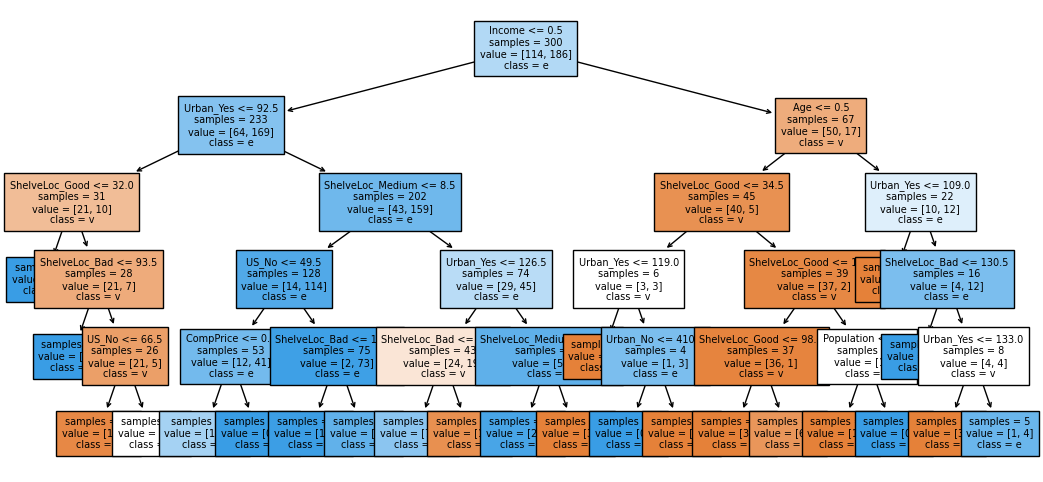

In [ ]:
# Estructura del árbol creado
# ------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(13, 6))
print(f"Profundidad del árbol: {modelo.get_depth()}")
print(f"Número de nodos terminales: {modelo.get_n_leaves()}")
plot = plot_tree(
decision_tree = modelo,
feature_names = labels.tolist(),
class_names = 'ventas_altas',
filled = True,
impurity = False,
fontsize = 7,
ax = ax
)

1 Predicción y evaluación del modelo
Se evalúa la capacidad predictiva del árbol inicial calculando el accuracy en el conjunto de test.

In [ ]:
# Error de test del modelo
#-------------------------------------------------------------------------------
predicciones = modelo.predict(X = X_test_prep,)
6
print("Matriz de confusión")
print("-------------------")
confusion_matrix(
y_true = y_test,
y_pred = predicciones
)

Matriz de confusión
-------------------


array([[29, 21],
       [ 7, 43]])

In [ ]:
accuracy = accuracy_score(
y_true = y_test,
y_pred = predicciones,
normalize = True
)
print(f"El accuracy de test es: {100 * accuracy} %")

El accuracy de test es: 72.0 %


1.0.1 Podado del árbol (pruning)
Aunque inicialmente se ha empleado un valor de max_depth=5, este no tiene por qué ser el mejor
valor. Con el objetivo de identificar la profundidad óptima que consigue reducir la varianza y
aumentar la capacidad predictiva del modelo, se somete al árbol a un proceso de pruning.

In [ ]:
# Post pruning (const complexity pruning) por validación cruzada
# ------------------------------------------------------------------------------
# Valores de ccp_alpha evaluados
param_grid = {'ccp_alpha':np.linspace(0, 5, 10)}
# Búsqueda por validación cruzada
grid = GridSearchCV(
# El árbol se crece al máximo posible antes de aplicar el pruning
estimator = DecisionTreeClassifier(
max_depth = None,
min_samples_split = 2,
min_samples_leaf = 1,
random_state = 123
),
param_grid = param_grid,
scoring = 'accuracy',
cv = 10,
refit = True,
return_train_score = True
)
7
grid.fit(X_train_prep, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=123),
             param_grid={'ccp_alpha': array([0.        , 0.55555556, 1.11111111, 1.66666667, 2.22222222,
       2.77777778, 3.33333333, 3.88888889, 4.44444444, 5.        ])},
             return_train_score=True, scoring='accuracy')

In [ ]:
# Mejor valor ccp_alpha encontrado
# ------------------------------------------------------------------------------
grid.best_params_

{'ccp_alpha': 0.0}

Una vez identificado el valor óptimo de ccp_alpha, se reentrena el árbol indicando este valor
en sus argumentos. Si en el GridSearchCV() se indica refit=True, este reentrenamiento se hace
automáticamente y el modelo resultante se encuentra almacenado en .best_estimator_.

In [ ]:
# Estructura del árbol final
# ------------------------------------------------------------------------------
modelo_final = grid.best_estimator_
print(f"Profundidad del árbol: {modelo_final.get_depth()}")
print(f"Número de nodos terminales: {modelo_final.get_n_leaves()}")

Profundidad del árbol: 9
Número de nodos terminales: 49


In [ ]:
# Error de test del modelo final
#-------------------------------------------------------------------------------
predicciones = modelo_final.predict(X = X_test_prep)
accuracy = accuracy_score(
y_true = y_test,
y_pred = predicciones,
normalize = True
)
print(f"El accuracy de test es: {100 * accuracy} %")

El accuracy de test es: 75.0 %


In [ ]:
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores = pd.DataFrame(
{'predictor': labels.tolist(),
'importancia': modelo_final.feature_importances_}
)
importancia_predictores.sort_values('importancia', ascending=False)

Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
11,Urban_Yes,0.267291
7,ShelveLoc_Bad,0.173585
1,Income,0.163736
8,ShelveLoc_Good,0.093583
9,ShelveLoc_Medium,0.089938
12,US_No,0.055480
6,Education,0.039439
4,Price,0.035371
0,CompPrice,0.033437
10,Urban_No,0.024170


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=3fc74dd6-4d86-415e-a82c-9f0616e61648' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>